In [40]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Device configuration (use GPU if available)
device = torch.device("cuda")

In [41]:
# Function to load an image and convert it to a tensor
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    
    # Resize the image
    if max_size:
        size = max(max(image.size), max_size)
    if shape:
        size = shape
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    
    return image.to(device)

# Load content and style images
content_image = load_image('/kaggle/input/content/content.png').to(device)
style_image = load_image('/kaggle/input/content/style.png', shape=content_image.shape[-2:]).to(device)


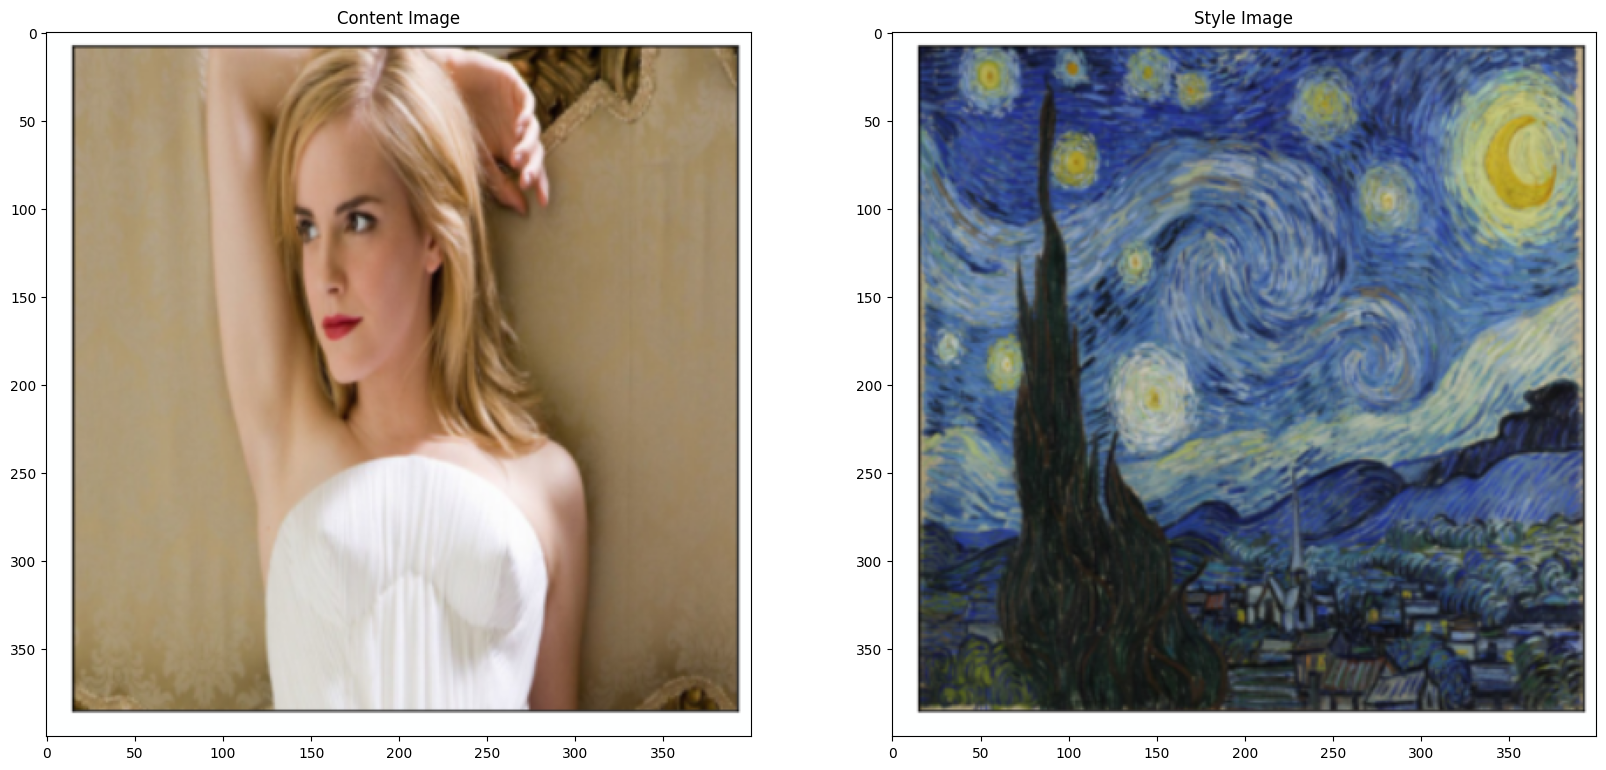

In [42]:
# Function to display an image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)
    return image

# Display content and style images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_image))
ax1.set_title("Content Image")

ax2.imshow(im_convert(style_image))
ax2.set_title("Style Image")

plt.show()

In [43]:
# Load the VGG19 model
vgg = models.vgg19(pretrained=True).features

# Freeze the parameters
for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [44]:
# Function to get features from the VGG19 model
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',  # 1st convolutional layer
            '5': 'conv2_1',  # 2nd convolutional layer
            '10': 'conv3_1', # 3rd convolutional layer
            '19': 'conv4_1', # 4th convolutional layer
            '21': 'conv4_2', # 4th convolutional layer, content extraction
            '28': 'conv5_1'  # 5th convolutional layer
        }
    
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

# Extract features from content and style images
content_features = get_features(content_image, vgg)
style_features = get_features(style_image, vgg)


In [45]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram 

# Calculate the gram matrices for the style features
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


In [46]:
# Initialize the target image with the content image
target = content_image.clone().requires_grad_(True).to(device)


In [47]:
# Define the weights for each style layer
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.8,
    'conv3_1': 0.5,
    'conv4_1': 0.3,
    'conv5_1': 0.1
}

# Define the weights for the content and style losses
content_weight = 1  # alpha
style_weight = 1e6  # beta


In [49]:
# Set up the optimizer
optimizer = optim.Adam([target], lr=0.003)

# Number of iterations
epochs = 4000

for i in range(epochs):
    # Get the features of the target image
    target_features = get_features(target, vgg)
    
    # Calculate the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    # Initialize the style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (target_feature.shape[1] * target_feature.shape[2])
    
    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # Update the target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Print the loss
    if i % 100 == 0:
        print(f"Epoch {i}/{epochs}, Total Loss: {total_loss.item()}")

# Display the final stylized image
final_image = target.cpu().clone().detach()
final_image = final_image.squeeze(0)

Epoch 0/4000, Total Loss: 325812160.0
Epoch 100/4000, Total Loss: 206638576.0
Epoch 200/4000, Total Loss: 124887280.0
Epoch 300/4000, Total Loss: 74878216.0
Epoch 400/4000, Total Loss: 46697152.0
Epoch 500/4000, Total Loss: 31100140.0
Epoch 600/4000, Total Loss: 22044364.0
Epoch 700/4000, Total Loss: 16483247.0
Epoch 800/4000, Total Loss: 12876266.0
Epoch 900/4000, Total Loss: 10422037.0
Epoch 1000/4000, Total Loss: 8642636.0
Epoch 1100/4000, Total Loss: 7336072.0
Epoch 1200/4000, Total Loss: 6410794.5
Epoch 1300/4000, Total Loss: 5862123.0
Epoch 1400/4000, Total Loss: 5055142.5
Epoch 1500/4000, Total Loss: 4639522.5
Epoch 1600/4000, Total Loss: 4199647.0
Epoch 1700/4000, Total Loss: 4132400.5
Epoch 1800/4000, Total Loss: 3677060.0
Epoch 1900/4000, Total Loss: 3432889.25
Epoch 2000/4000, Total Loss: 3287857.0
Epoch 2100/4000, Total Loss: 3068013.5
Epoch 2200/4000, Total Loss: 2945995.0
Epoch 2300/4000, Total Loss: 2784395.5
Epoch 2400/4000, Total Loss: 2708596.75
Epoch 2500/4000, Total

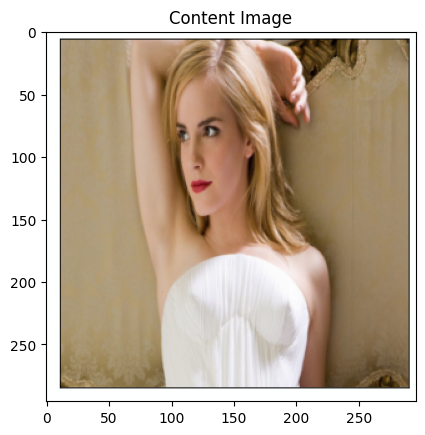

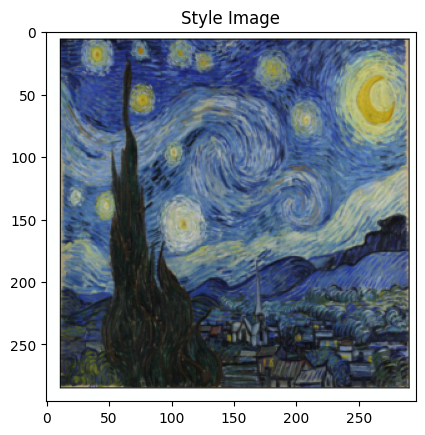

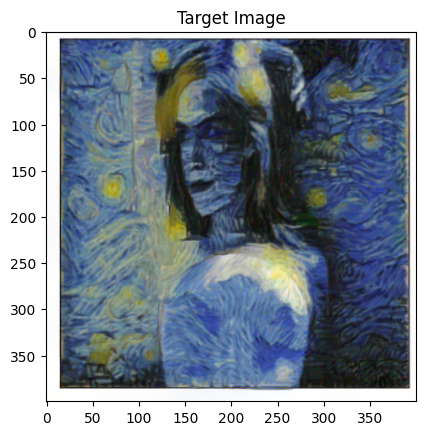

In [53]:
# Display the content image
# content = im_convert(content)
plt.imshow(content)
plt.title("Content Image")
plt.show()

# Display the style image
style = im_convert(style)
plt.imshow(style)
plt.title("Style Image")
plt.show()

# Display the target image
final_image = im_convert(final_image)
plt.imshow(final_image)
plt.title("Target Image")
plt.show()